In [ ]:
import numpy as np
import matplotlib.pyplot as plt

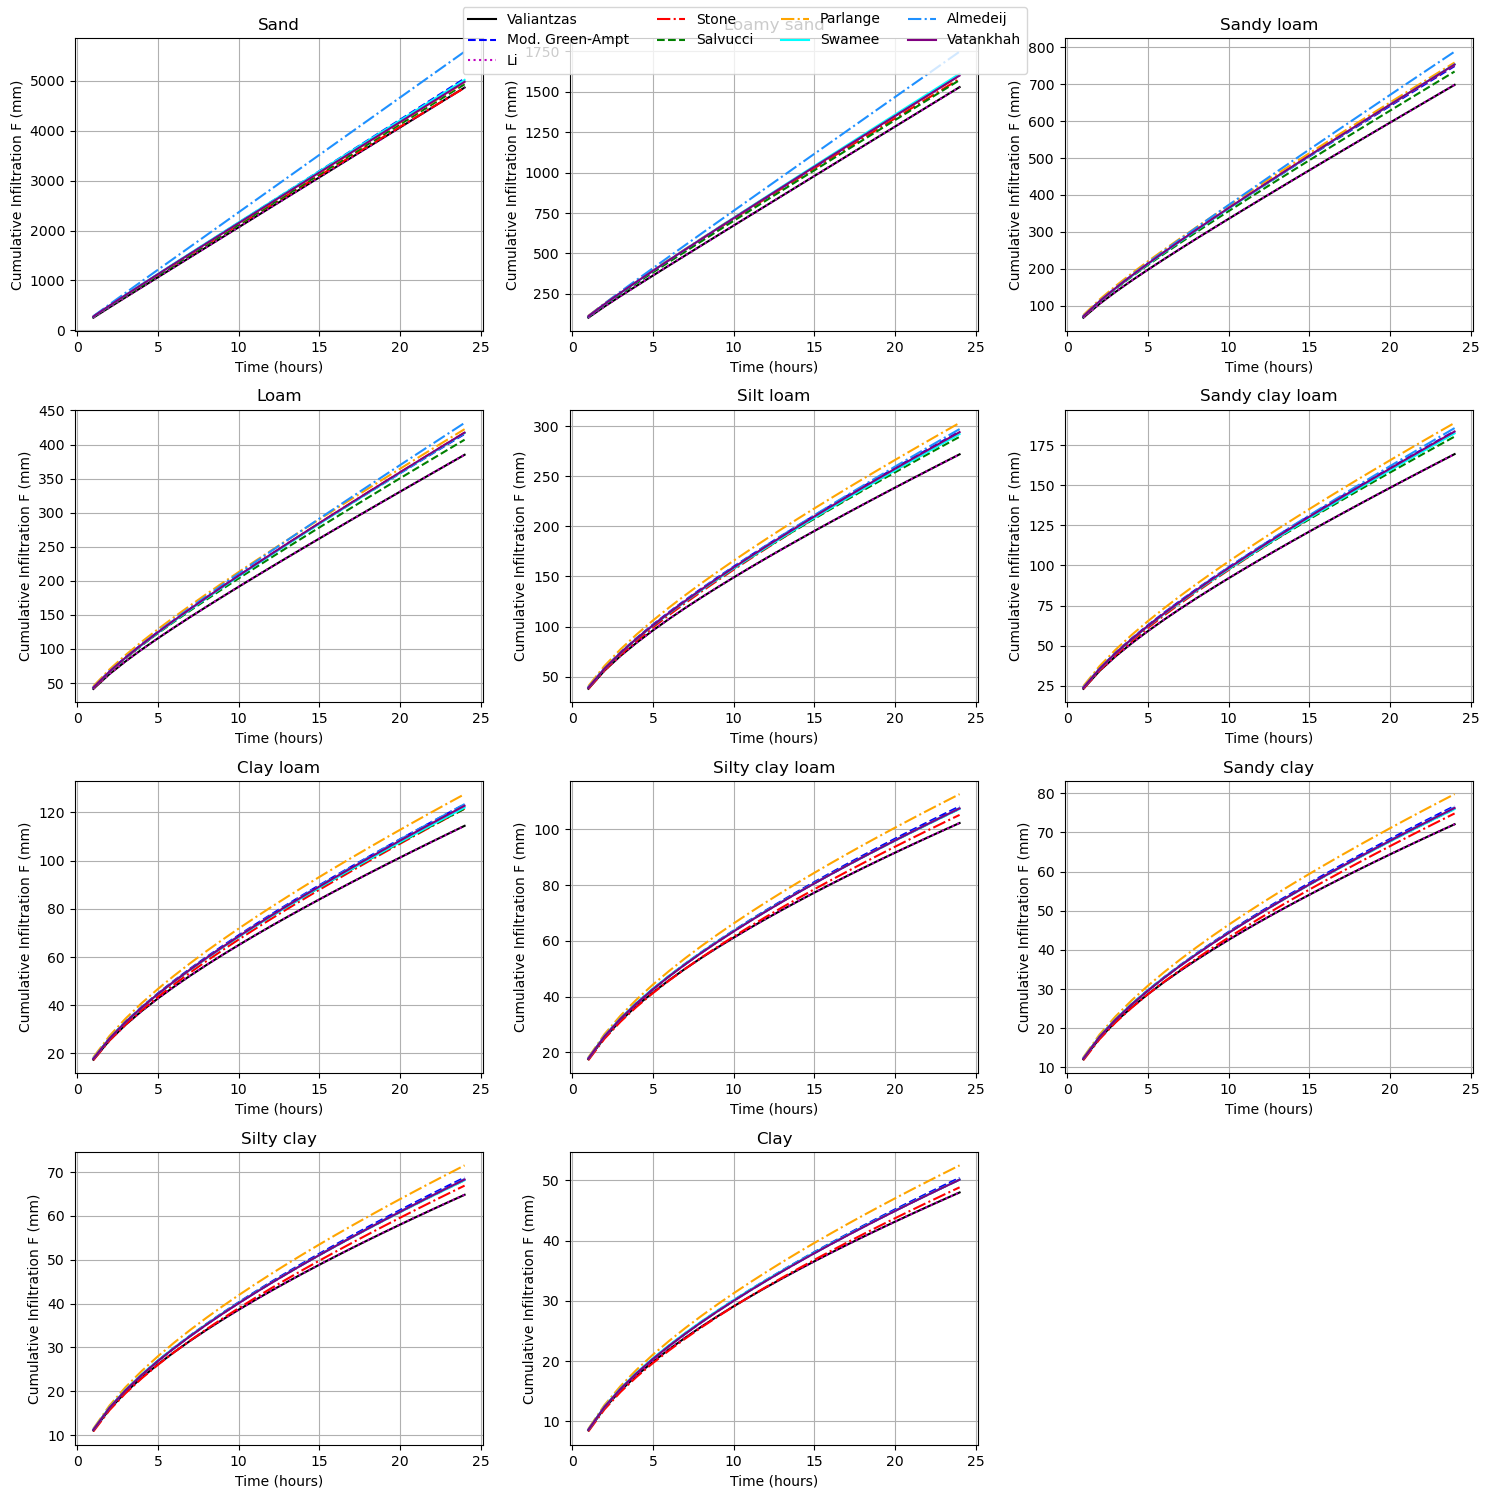

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

In [74]:
# Time steps (in hours)
time_hours = np.arange(1, 25)  # 24-hour period

# Define soil data with Ks and S values for different soil types (units: Ks in mm/h, S in mm/h^0.5)
soil_data = {
    "Sand": {"Ks": 200.0, "S": 116.6},
    "Loamy sand": {"Ks": 61.0, "S": 64.4},
    "Sandy loam": {"Ks": 25.0, "S": 53.4},
    "Loam": {"Ks": 13.0, "S": 34.2},
    "Silt loam": {"Ks": 7.0, "S": 34.3},
    "Sandy clay loam": {"Ks": 4.5, "S": 20.8},
    "Clay loam": {"Ks": 2.5, "S": 16.1},
    "Silty clay loam": {"Ks": 1.5, "S": 16.8},
    "Sandy clay": {"Ks": 1.2, "S": 11.4},
    "Silty clay": {"Ks": 1.0, "S": 10.5},
    "Clay": {"Ks": 0.6, "S": 8.2}
}

# Instantiate InfiltrationModel class
class InfiltrationModel:
    def __init__(self, Ks, S):
        self.Ks = Ks
        self.S = S
        self.chi = (S**2) / (2 * Ks**2)

    def dimensionless_time(self, t):
        return (2 * self.Ks**2 * t) / self.S**2

    #Valiantzas (2012):New linearized two-parameter infiltration equation for direct determination of conductivity and sorptivity
    def valiantzas_model(self, t): 
        return 0.5 * self.Ks * t + self.S * np.sqrt(t * (1 + (0.5 * self.Ks / self.S)**2 * t))

    #Sadeghi et al. (2024): A simple, accurate, and explicit form of the Green–Ampt model to estimate infiltration, sorptivity, and hydraulic conductivity
    def sadeghi_model(self, t): 
        return self.Ks * t * (0.70635 + 0.32415 * np.sqrt(1 + 9.43456 * (self.S**2) / (self.Ks**2 * t)))

    #Li et al. (1976): Solutions to Green–Ampt infiltration equation
    def li_model(self, t): 
        t_star = self.dimensionless_time(t)
        return (0.5*self.S**2 / (2 * self.Ks)) * (t_star + np.sqrt(t_star**2 + 8 * t_star))
    
    #Stone et al. (1994): Approximate form of Green–Ampt infiltration equation
    def stone_model(self, t): 
        t_star = self.dimensionless_time(t)
        return (self.S**2 / (2 * self.Ks)) * (t_star + np.sqrt(2 * t_star) - 0.2987 * t_star**0.7913)

    #Salvucci and Entekhabi (1994): Explicit expressions for Green–Ampt (delta function diffusivity) infiltration rate and cumulative storage
    def salvucci_entekhabi_model(self, t):
        term1 = (1 - np.sqrt(2) / 3) * t
        term2 = (np.sqrt(2) / 3) * np.sqrt(self.chi * t + t**2)
        term3 = (np.sqrt(2) - 1) / 3 * self.chi * (np.log(t + self.chi) - np.log(self.chi))
        term4 = (np.sqrt(2) / 3) * self.chi * (np.log(t + (self.chi / 2) + np.sqrt(self.chi * t + t**2)) - np.log(self.chi / 2))
        return self.Ks * (term1 + term2 + term3 + term4)

    #Parlange et al. (2002): Explicit infiltration equations and the Lambert W-function
    def parlange_model(self, t):
        t_star = self.dimensionless_time(t)
        return (self.S**2 / (2 * self.Ks)) * (t_star + np.log(1 + t_star + np.sqrt(2 * t_star)))

    #Swamee et al. (2012):Explicit equations for infiltration
    def swamee_model(self, t):
        t_star = self.dimensionless_time(t)
        return (self.S**2 / (2 * self.Ks)) * (1.94 * t_star**0.74 + t_star**1.429)**0.7

    #Almedeij and Essen. (2014): Modified Green–Ampt infiltration model for steady rainfall
    def almedeij_model(self, t):
        t_star = self.dimensionless_time(t)
        return (self.S**2 / (2 * self.Ks)) * (0.65 * t_star + np.sqrt(0.25 * t_star**2 + 2 * t_star))

    #Vatankhah, A.R., 2015.Discussion of modified Green–Ampt infiltration model for steady rainfall by J. Almedeij and I.I. Esen
    def vatankhah_model(self, t):
        t_star = self.dimensionless_time(t)
        return (self.S**2 / (2 * self.Ks)) * (t_star + 2.693 * np.log(1 + 0.527 * np.sqrt(t_star)))

    def get_model(self, model_name, t):
        model_func = self.models.get(model_name)
        if model_func:
            return model_func(t)
        else:
            raise ValueError(f"Model '{model_name}' not found. Available models: {list(self.models.keys())}")

    @property
    def models(self):
        return {
            "valiantzas_model": self.valiantzas_model,
            "sadeghi_model": self.sadeghi_model,
            "li_model": self.li_model,
            "stone_model": self.stone_model,
            "salvucci_entekhabi": self.salvucci_entekhabi_model,
            "parlange_model": self.parlange_model,
            "swamee_model": self.swamee_model,
            "almedeij_model": self.almedeij_model,
            "vatankhah_model": self.vatankhah_model
        }

# Create subplots for each soil type
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()

# Loop through each soil type and plot results for each model
for i, (soil, params) in enumerate(soil_data.items()):
    Ks, S = params["Ks"], params["S"]
    model = InfiltrationModel(Ks, S)
    
    # Calculate cumulative infiltration for each model
    F_valiantzas = [model.get_model("valiantzas_model", t) for t in time_hours]
    F_ga = [model.get_model("sadeghi_model", t) for t in time_hours]
    F_li = [model.get_model("li_model", t) for t in time_hours]
    F_stone = [model.get_model("stone_model", t) for t in time_hours]
    F_salvucci = [model.get_model("salvucci_entekhabi", t) for t in time_hours]
    F_parlange = [model.get_model("parlange_model", t) for t in time_hours]
    F_swamee = [model.get_model("swamee_model", t) for t in time_hours]
    F_almedeij = [model.get_model("almedeij_model", t) for t in time_hours]
    F_vatankhah = [model.get_model("vatankhah_model", t) for t in time_hours]
    
    # Plot each model's results in the subplot for the current soil type
    ax = axes[i]
    ax.plot(time_hours, F_valiantzas, label="Valiantzas", c="k")
    ax.plot(time_hours, F_ga, label="Sadeghi", linestyle="--", c="b")
    ax.plot(time_hours, F_li, label="Li", linestyle=":", c='m')
    ax.plot(time_hours, F_stone, label="Stone", linestyle="-.", c='r')
    ax.plot(time_hours, F_salvucci, label="Salvucci_E", linestyle="--", c='g')
    ax.plot(time_hours, F_parlange, label="Parlange", linestyle="-.", c='orange')
    ax.plot(time_hours, F_swamee, label="Swamee", linestyle="-", c='cyan')
    ax.plot(time_hours, F_almedeij, label="Almedeij", linestyle="-.", c='dodgerblue')
    ax.plot(time_hours, F_vatankhah, label="Vatankhah", linestyle="-", c='purple')
    
    ax.set_title(soil)
    ax.set_xlabel("Time (hours)")
    ax.set_ylabel("Cumulative Infiltration F (mm)")
    ax.grid(True)
axes.flat[-1].set_visible(False) # to remove last plot
# Adjust layout and add legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show
